# Caracterización de Base de datos

In [ ]:
#### Autor: Bastián Mendoza Cerda
### Rut: 19.185.429-2

A continuación se detallarán los valores que posee cada columna (valores únicos) y lo que significa/implica cada columna para el resultado final que será un resultado binario, es decir: Se aprueba o no el crédito hipotecario.

In [1]:
# Imports de librerías útiles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import missingno as msno
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
data_v1 = pd.read_csv('dprestamos.csv')
data_v1.head()

,ID_prestamo,genero,estado_civil_casado,dependientes,educacion_universitaria,emprendedor,ingreso_postulante,ingreso_codeudor,monto_credito,plazo_credito,historia_crediticia,area_propiedad,aprobacion_credito
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
print(f'Se tienen {len(data_v1.columns.tolist())} columnas en el dataframe')

Se tienen 13 columnas en el dataframe


Entonces, se tienen 13 columnas en el dataframe, de las cuales 11 corresponden a features o características de cada persona que se postula para obtener un crédito hipotecario.

La columna 'ID_prestamo' no contribuye en nada al modelo predictivo dado que corresponde a una columna con valores únicos para cada fila, ie: es un índice solamente, por lo que se puede eliminar

In [4]:
print(f'La cantidad de valores únicos en la columna ID_prestamo son: ' + str(len(data_v1['ID_prestamo'].unique())) )

La cantidad de valores únicos en la columna ID_prestamo son: 614


In [5]:
print(f'La cantidad de valores presentes en la columna ID_prestamo son: ' + str(len(data_v1['ID_prestamo'])) )

La cantidad de valores presentes en la columna ID_prestamo son: 614


Lo que corrobora la hipótesis inicial.

Ahora resta caracterizar las 11 columnas de features además de realizar un procesamiento binario para el valor Y (o valor objetivo) que resulta ser la aprobación del crédito (Sí/No o 1/0).

In [6]:
df = data_v1.drop(columns=['ID_prestamo'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   genero                   601 non-null    object 
 1   estado_civil_casado      611 non-null    object 
 2   dependientes             599 non-null    object 
 3   educacion_universitaria  614 non-null    object 
 4   emprendedor              582 non-null    object 
 5   ingreso_postulante       614 non-null    int64  
 6   ingreso_codeudor         614 non-null    float64
 7   monto_credito            592 non-null    float64
 8   plazo_credito            600 non-null    float64
 9   historia_crediticia      564 non-null    float64
 10  area_propiedad           614 non-null    object 
 11  aprobacion_credito       614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [8]:
df.describe()

,ingreso_postulante,ingreso_codeudor,monto_credito,plazo_credito,historia_crediticia
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
df['aprobacion_credito'].value_counts()

Y    422
N    192
Name: aprobacion_credito, dtype: int64

Se tiene un claro desbalance entre clases, por lo que se debe tener en cuenta al momento de entrenar un modelo.

## Análisis de variables categóricas

In [10]:
df_c = df.drop(columns=['ingreso_postulante','ingreso_codeudor','monto_credito','plazo_credito','aprobacion_credito','historia_crediticia'])

In [11]:
print('Los valores únicos de las columnas no correspondientes a montos/aprobacion son:')

print('\n')

for col in df_c:
    print(f'La columna {col.capitalize()} tiene : {(df_c[col].unique())}')

Los valores únicos de las columnas no correspondientes a montos/aprobacion son:


La columna Genero tiene : ['Male' 'Female' nan]
La columna Estado_civil_casado tiene : ['No' 'Yes' nan]
La columna Dependientes tiene : ['0' '1' '2' '3+' nan]
La columna Educacion_universitaria tiene : ['Graduate' 'Not Graduate']
La columna Emprendedor tiene : ['No' 'Yes' nan]
La columna Area_propiedad tiene : ['Urban' 'Rural' 'Semiurban']


Debido a que existen missing values se debe hacer un tratamiento de ellos previo a entrenar algún modelo con la base de datos.

## Análisis de variables numéricas

Para analizar las variables numéricas que componen el dataframe se realizará un **pairplot** con ayuda de la librería seaborn y posteriormente un heatmap para observar correlaciones entre los datos numéricos.

In [12]:
df_n = df[['ingreso_postulante','ingreso_codeudor','monto_credito','plazo_credito']]

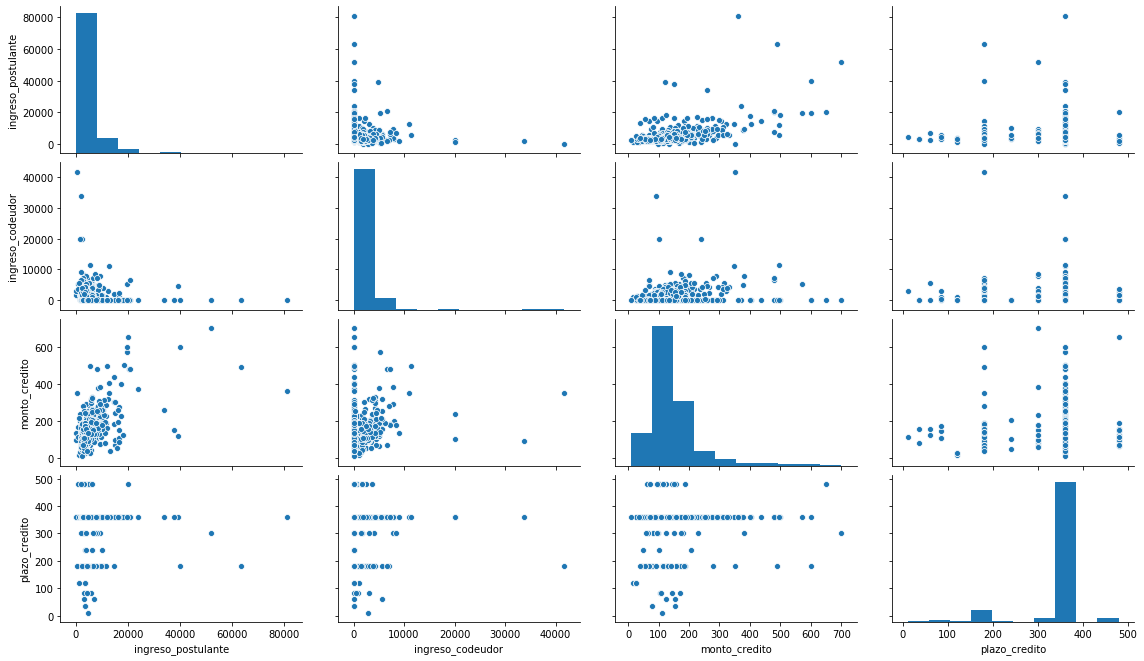

In [13]:
sns.pairplot(df_n).fig.set_size_inches(16,9)

[]

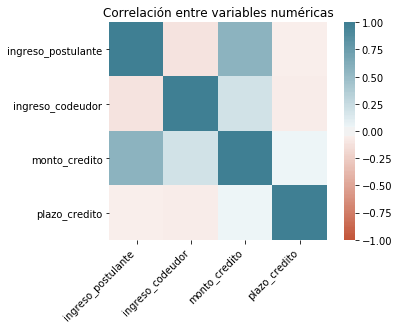

In [14]:
corr = df_n.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlación entre variables numéricas')
ax.plot()

Con lo cual preliminarmente existe una cierta correlación entre:

1) Monto del crédito - Ingreso del postulante.

2) Plazo del crédito - Monto del crédito.

3) Monto del crédito - Ingreso del codeudor.

## Análisis de missing values

Como primer acercamiento se analizará cuántos filas existen con missing values y si es significativa su cifra para evaluar si es posible eliminar dicha data para efectos de entrenamiento.

In [15]:
print('Análisis de valores NaN: ')
print('\n')
print('Los valores NaN se distribuyen como siguen en las distintas 12 variables:')
print('\n')
print(df.isnull().sum())
print('\n')
print(f'Teniendo la base un total de {df.isnull().sum().sum()} valores faltantes entre todas las variables y un largo total de {df.shape[0]} filas')

Análisis de valores NaN: 


Los valores NaN se distribuyen como siguen en las distintas 12 variables:


genero                     13
estado_civil_casado         3
dependientes               15
educacion_universitaria     0
emprendedor                32
ingreso_postulante          0
ingreso_codeudor            0
monto_credito              22
plazo_credito              14
historia_crediticia        50
area_propiedad              0
aprobacion_credito          0
dtype: int64


Teniendo la base un total de 149 valores faltantes entre todas las variables y un largo total de 614 filas


Utilizando la librería missingno se puede visualizar la ocurrencia de **"missing values"** y si existe alguna relación de ocurrencia entre ellos.

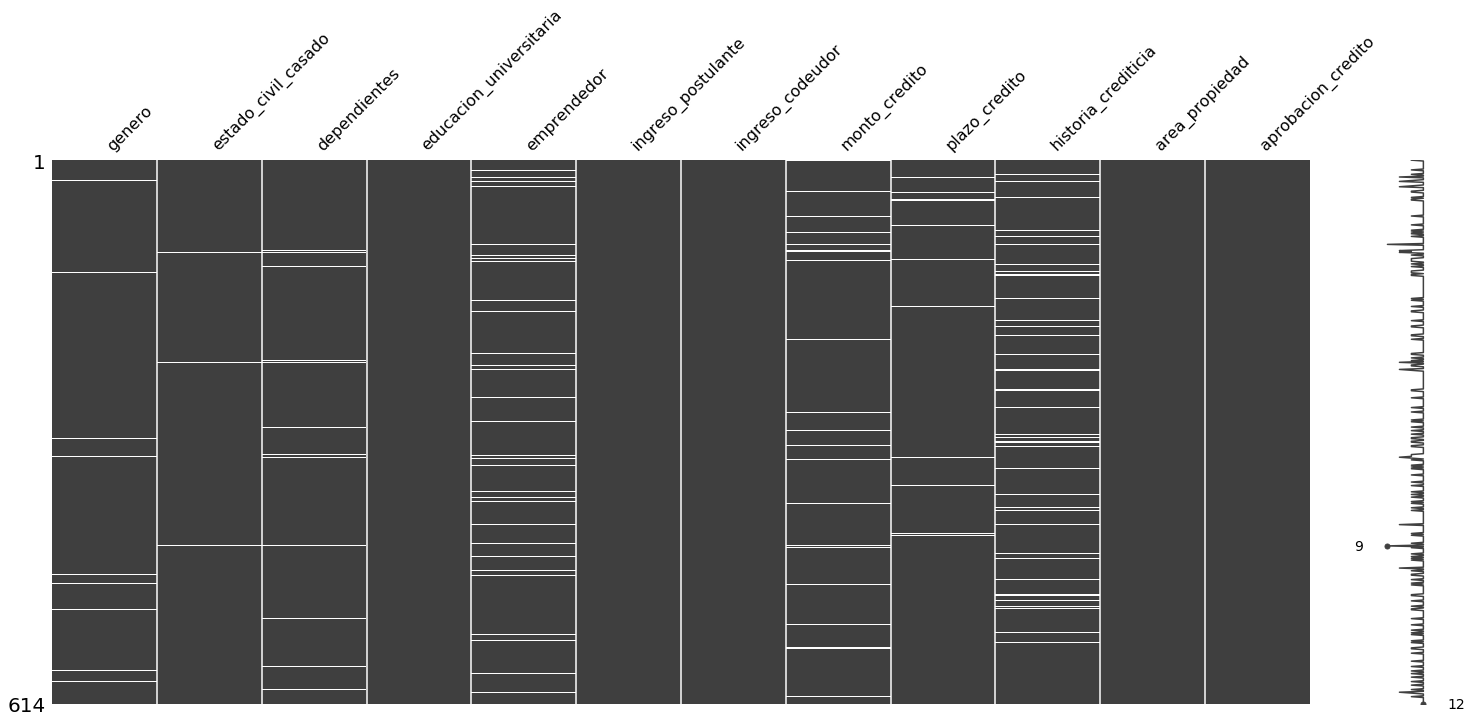

In [16]:
msno.matrix(df)

Se eliminan las columnas que no tienen **missing values** para analizar la ocurrencia de NaNs.

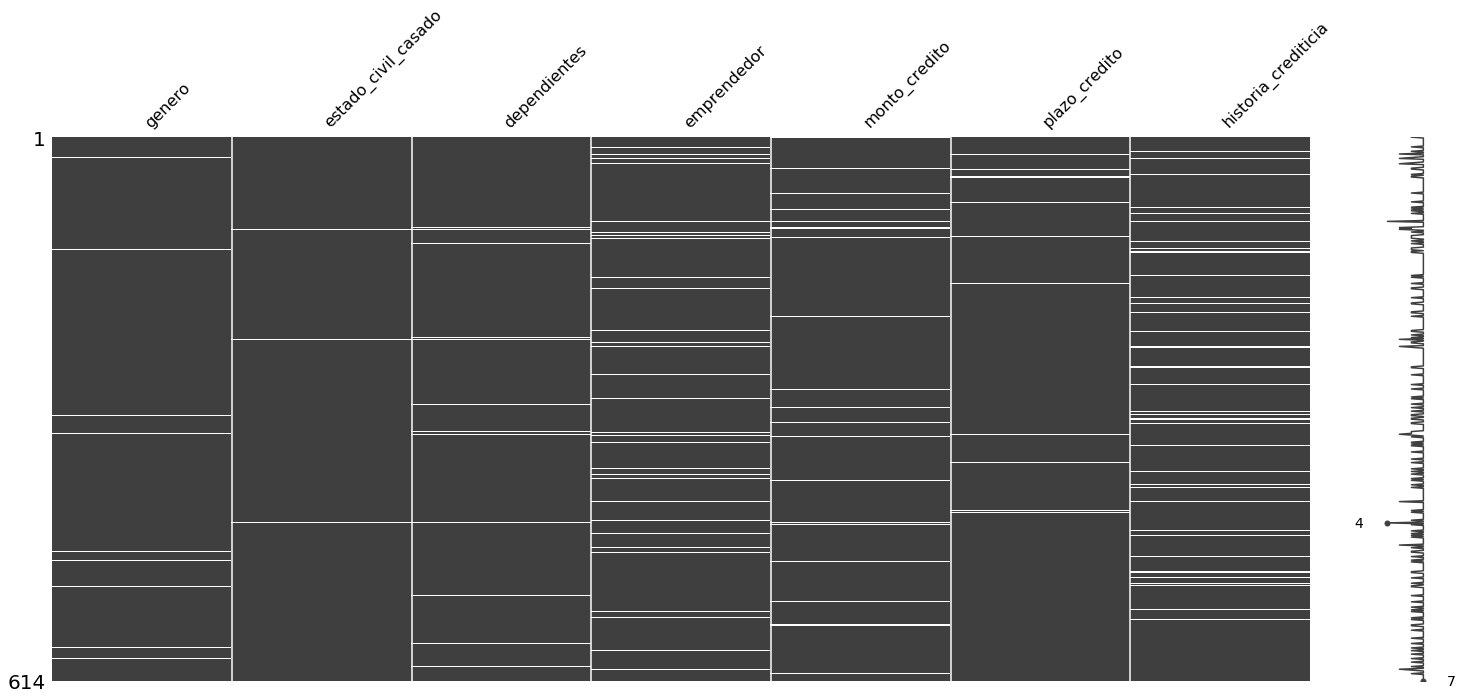

In [17]:
msno.matrix(df.drop(columns=['educacion_universitaria','ingreso_postulante','ingreso_codeudor','area_propiedad','aprobacion_credito']))

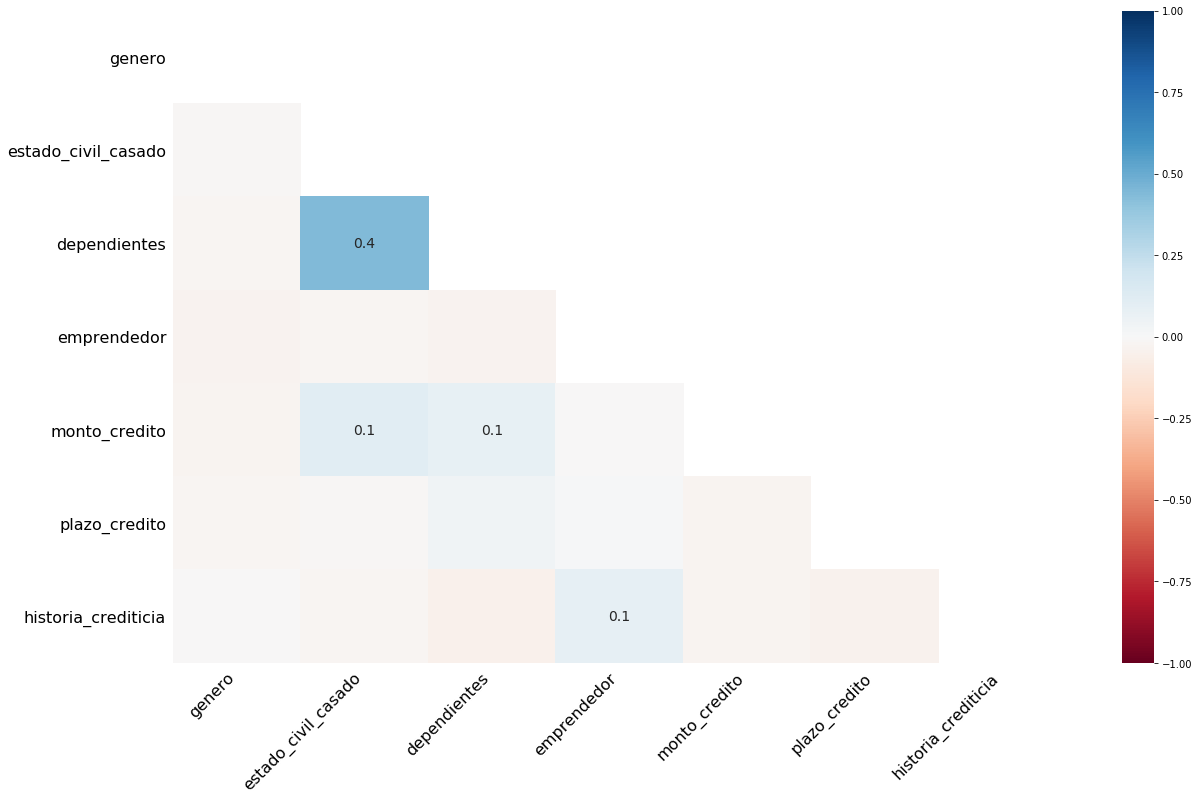

In [18]:
msno.heatmap(df.drop(columns=['educacion_universitaria','ingreso_postulante','ingreso_codeudor','area_propiedad','aprobacion_credito']))

Observando la ocurrencia de missing values en el dataset junto con el heatmap de NaN's entre variables, se tiene que la columna **estado_civil_casado** tiene cierta correlación con **dependientes** lo cual obedece la lógica debido a que si una persona está oficialmente casada, ésta posee una mayor probabilidad de tener como dependientes a personas.

Además de que pasa que en caso de tener un missing value en la columna **estado_civil_casado**, siempre hay un missing value en la columna **dependientes**.

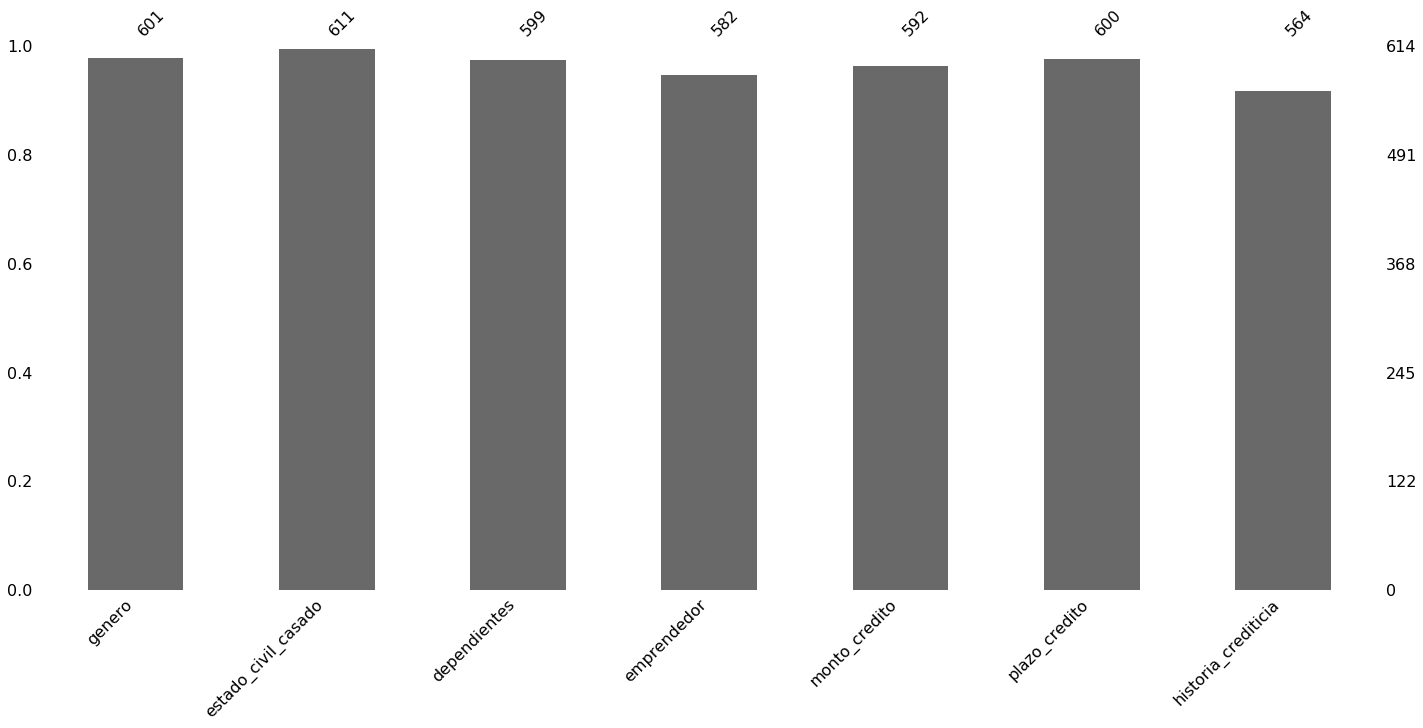

In [19]:
#Con esto se puede observar gráficamente los missing values por columna
msno.bar(df.drop(columns=['educacion_universitaria','ingreso_postulante','ingreso_codeudor','area_propiedad','aprobacion_credito']))

Eliminando los missing values como un primer acercamiento al problema se tiene:

In [20]:
print('Análisis de base posterior a eliminar los valores NaN: ')
print('\n')
print(df.dropna().isnull().sum())
print('\n')
print(f'Quedando con un total de {df.dropna().shape[0]} filas para el entrenamiento del modelo.')
print(f'Lo que disminuye el tamaño de la base en un {round(100-((df.dropna().shape[0]*100)/df.shape[0]))}% aproximadamente')

Análisis de base posterior a eliminar los valores NaN: 


genero                     0
estado_civil_casado        0
dependientes               0
educacion_universitaria    0
emprendedor                0
ingreso_postulante         0
ingreso_codeudor           0
monto_credito              0
plazo_credito              0
historia_crediticia        0
area_propiedad             0
aprobacion_credito         0
dtype: int64


Quedando con un total de 480 filas para el entrenamiento del modelo.
Lo que disminuye el tamaño de la base en un 22% aproximadamente


## Desempeño eliminando Missing Values

In [21]:
def transformar_base(df):
    df['aprobacion_credito'] = df['aprobacion_credito'].replace('Y',1)
    df['aprobacion_credito'] = df['aprobacion_credito'].replace('N',0)
    return df

In [22]:
df=transformar_base(df)

Se divide el dataset entre X (features) e y (variable objetivo)

In [23]:
df_x = df.dropna().iloc[:, :-1].values
df_y = df.dropna().iloc[:, -1].values

In [24]:
df.dropna()['aprobacion_credito'].value_counts()

1    332
0    148
Name: aprobacion_credito, dtype: int64

Se utiliza OneHotEncoding para codificar las variables categóricas, manteniendo los valores dentro de la misma columna en caso de que tengan una naturaleza binaria (Yes/No, Hombre/Mujer, etc.)

In [25]:
#Se crea el Encoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='if_binary'), [0,1,2,3,4,10])], remainder='passthrough')
#Se aplica el encoder a las variables categóricas
X = np.array(ct.fit_transform(df_x))

#Se crea el estandarizador para cuando los datos sean ingresados en el modelo de regresión logística.
sc = StandardScaler()

y = df_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#Se ajusta y aplica el estandarizado a las variables numéricas en training
X_train[:, 5:9] = sc.fit_transform(X_train[:, 5:9])
#Se aplica el estandarizado a las variables numéricas en test
X_test[:, 5:9] = sc.transform(X_test[:, 5:9])


In [26]:
print('Array dataset de entrenamiento:')
print('\n')
print(X_train)
print('\n')
print('Array dataset de test:')
print('\n')
print(X_test)

Array dataset de entrenamiento:


[[1.0 1.0 1.0 ... 115.0 180.0 1.0]
 [0.0 0.0 1.0 ... 135.0 360.0 1.0]
 [1.0 1.0 0.0 ... 480.0 360.0 1.0]
 ...
 [0.0 0.0 0.0 ... 40.0 360.0 1.0]
 [0.0 1.0 0.0 ... 135.0 360.0 1.0]
 [0.0 1.0 1.0 ... 100.0 360.0 1.0]]


Array dataset de test:


[[1.0 0.0 1.0 ... 71.0 480.0 1.0]
 [1.0 0.0 1.0 ... 133.0 360.0 1.0]
 [1.0 1.0 1.0 ... 144.0 360.0 1.0]
 ...
 [1.0 0.0 1.0 ... 145.0 360.0 1.0]
 [1.0 0.0 1.0 ... 81.0 300.0 1.0]
 [1.0 0.0 1.0 ... 98.0 360.0 0.0]]


In [27]:
##Función para una matriz de confusión más imponente
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor verdadero')
    plt.xlabel('Valor estimado \n por el modelo')

### Modelo de Clasificador con XGBoost

#### Modelo XGBoost por defecto

Se utilizará como primer modelo un XGBoost y se irán tuneando los hiper parámetros en caso de ser necesario

In [28]:
#parámetros modelo 1: default

model1 = xgb.XGBClassifier()

train_model1 = model1.fit(X_train, y_train)

In [29]:
#Se crean funciones para así utilizar la probabilidad de pertenencia a las clases
#apruebo(1) o rechazo(0) prestamo
#y darles importancia de acuerdo a los requerimientos del negocio
#debido a que es deseable que a toda persona que se le apruebe
#el crédito sea capaz de pagarlo (en términos de números)
#por lo que se debe priorizar la minimización de
#casos falsos positivos (aprobar el crédito a una persona que no puede pagar)

def predict_(modelo, x_test, umbral):
    probs = modelo.predict_proba(x_test)
    probs = probs[:, 1]
    preds = [1 if p >= umbral else 0 for p in probs]
    return preds

def mult_predict(modelo,x_test,umbrales,y_test):
    probs = modelo.predict_proba(x_test)
    probs = probs[:,1]
    f={}
    r={}
    f1_score(y_test, pred1, average='weighted')
    for umbral in umbrales:
        preds = [1 if p >= umbral else 0 for p in probs]
        f[str(umbral)] = np.round(f1_score(y_test, preds,average='weighted'),3)
        r[str(umbral)] = np.round(recall_score(y_test, preds, average=None)[0],3)
        
    return f,r
    

Aterrizando las métricas al mercado, se tiene que:

- Precisión: Hace alusión al porcentaje de personas que el modelo etiquetó como "aprobar crédito" y efectivamente tenían aprobado el crédito.


- Recall: Se refiere al porcentaje de personas que se logran etiquetar como "aprobar crédito" o "rechazar crédito" entre todas las que se etiquetaron como "aprobar crédito" o "rechazar crédito" (independiente de si correspondía o no).


- F1 - Score: Es una métrica que establece una relación entre precisión y recall, así se puede observar como una sola métrica.


- Exactitud: Mide el procentaje de casos en los que el modelo ha acertado entre el total de casos, métrica la cual puede ser muy mentirosa debido a que no funciona bien cuando las clases están desbalanceadas.

In [30]:
from sklearn.metrics import classification_report

pred1 = predict_(model1,X_test,0.9)

In [31]:
#Se buscará el valor umbral que maximice el recall de la clase 0
#Lo que implica que se buscará el umbral que haga que la identificación de
#personas que no tiene que aprobárseles el crédito sea lo más precisa posible.

fscores_1,recalls_1 = mult_predict(model1,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_1 = sorted(fscores_1.items())
list_recalls_1 = sorted(recalls_1.items())

In [32]:
print(fscores_1)
print(recalls_1)

{'0.0': 0.52, '0.1': 0.657, '0.2': 0.67, '0.3': 0.661, '0.4': 0.675, '0.5': 0.666, '0.6': 0.671, '0.7': 0.675, '0.8': 0.627, '0.9': 0.604}
{'0.0': 0.0, '0.1': 0.273, '0.2': 0.333, '0.3': 0.333, '0.4': 0.364, '0.5': 0.364, '0.6': 0.394, '0.7': 0.424, '0.8': 0.485, '0.9': 0.606}


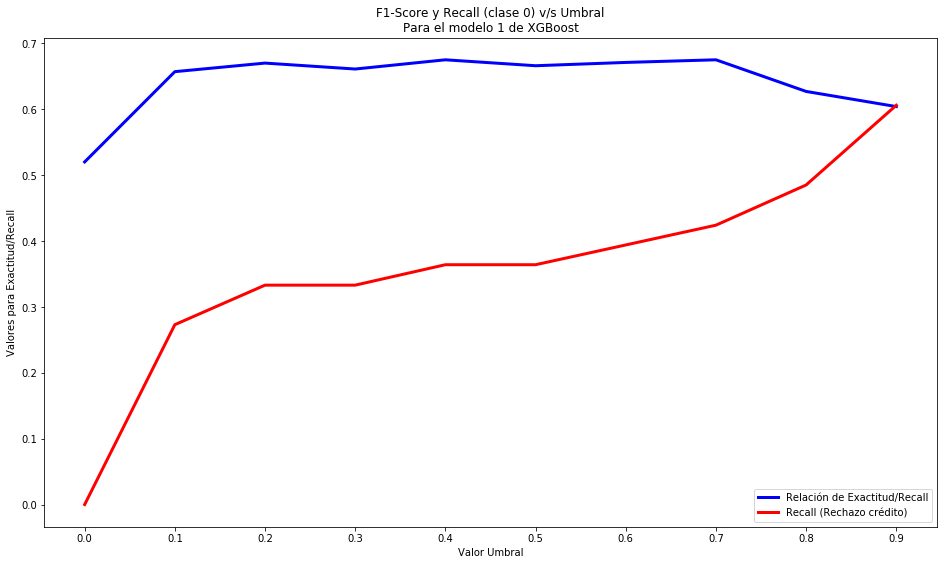

In [33]:
x_1, y_1 = zip(*list_fscores_1) # unpack a list of pairs into two tuples
x2_1, y2_1 = zip(*list_recalls_1)

fig_1 = plt.figure(figsize=(16,9))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(x_1,y_1, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_1.plot(x2_1,y2_1, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_1.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 1 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_1.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.9 para el modelo 1.

In [34]:
print('Reporte de clasificación para el modelo 1 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred1))}')

Reporte de clasificación para el modelo 1 de XGboost


              precision    recall  f1-score   support

           0       0.43      0.61      0.51        33
           1       0.74      0.59      0.65        63

    accuracy                           0.59        96
   macro avg       0.59      0.60      0.58        96
weighted avg       0.64      0.59      0.60        96



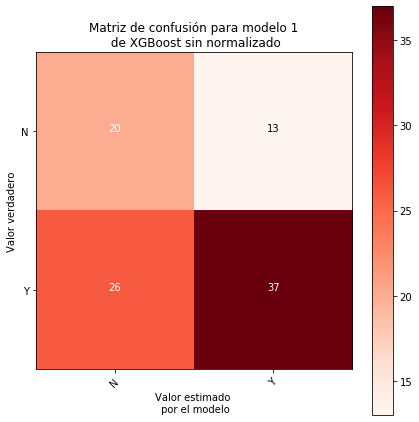

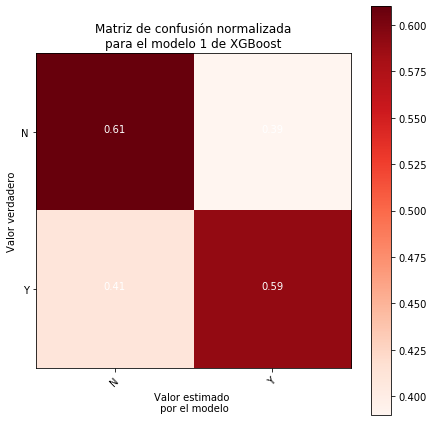

In [35]:
cnf_matrix_xgb1 = confusion_matrix(y_test.ravel(), pred1)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb1, classes=(['N','Y']), title='Matriz de confusión para modelo 1\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb1, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 1 de XGBoost')

plt.show()

In [36]:
print("Exactitud para el modelo 1: %.2f" % (accuracy_score(y_test, pred1) * 100))

Exactitud para el modelo 1: 59.38


Area bajo la curva característica para el modelo 1: 0.597


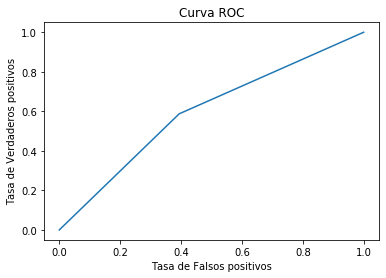

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, pred1)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 1:', 
      np.round(roc_auc_score(y_test, pred1),3))

#### Modelo XGBoost 2 modificado

In [38]:
#parámetros modelo 2: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5

model2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.5,
    eval_metric='auc')

train_model2 = model2.fit(X_train, y_train)

In [39]:
pred2 = predict_(model2,X_test,0.8)

In [40]:
fscores_2,recalls_2 = mult_predict(model2,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_2 = sorted(fscores_2.items())
list_recalls_2 = sorted(recalls_2.items())

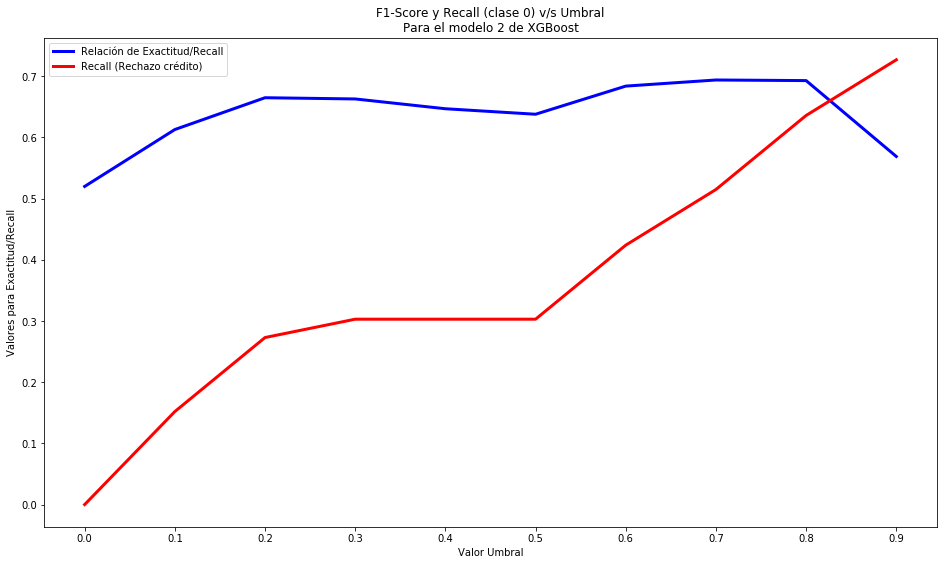

In [41]:
x_2, y_2 = zip(*list_fscores_2) # unpack a list of pairs into two tuples
x2_2, y2_2 = zip(*list_recalls_2)

fig_2 = plt.figure(figsize=(16,9))
ax_2 = fig_2.add_subplot(111)
ax_2.plot(x_2,y_2, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_2.plot(x2_2,y2_2, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_2.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 2 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_2.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.8 para el modelo 2.

In [42]:
print('Reporte de clasificación para el modelo 2 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred2))}')

Reporte de clasificación para el modelo 2 de XGboost


              precision    recall  f1-score   support

           0       0.54      0.64      0.58        33
           1       0.79      0.71      0.75        63

    accuracy                           0.69        96
   macro avg       0.66      0.68      0.67        96
weighted avg       0.70      0.69      0.69        96



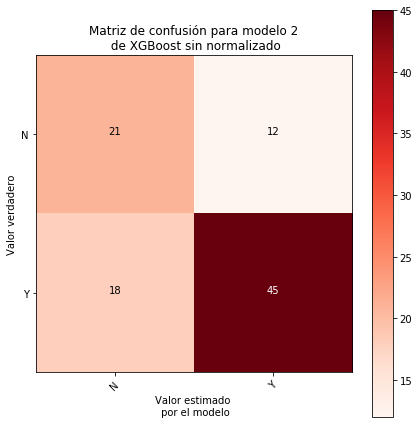

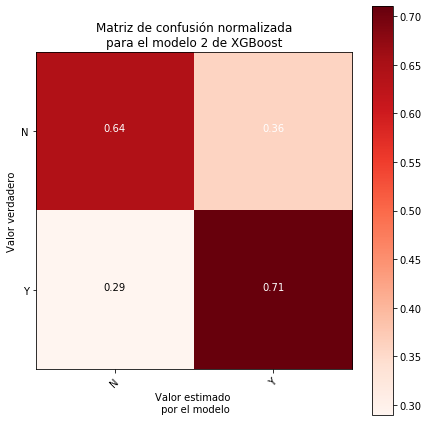

In [43]:
cnf_matrix_xgb2 = confusion_matrix(y_test.ravel(), pred2)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb2, classes=(['N','Y']), title='Matriz de confusión para modelo 2\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb2, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 2 de XGBoost')

plt.show()

In [44]:
print("Exactitud para el modelo 2: %.2f" % (accuracy_score(y_test, pred2) * 100))

Exactitud para el modelo 2: 68.75


Area bajo la curva característica para el modelo 2: 0.675


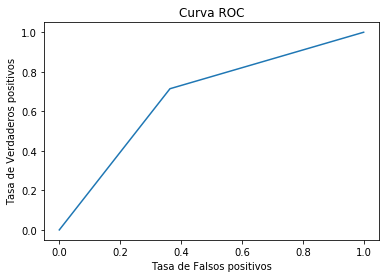

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, pred2)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 2:', 
      np.round(roc_auc_score(y_test, pred2),3))

Debido a que aún el desempeño es regular, se realizará un "tuneo de los hiper parámetros" que componen al modelo XGBoost y se agregarán argumentos para "hilar más fino" de ser posible

#### Modelo XGBoost 3 con un mayor grado de hiper parámetros modificados

In [46]:
model3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 eval_metric='auc',
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [47]:
train_model3 = model3.fit(X_train, y_train)

In [48]:
fscores_3,recalls_3 = mult_predict(model3,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_3 = sorted(fscores_3.items())
list_recalls_3 = sorted(recalls_3.items())

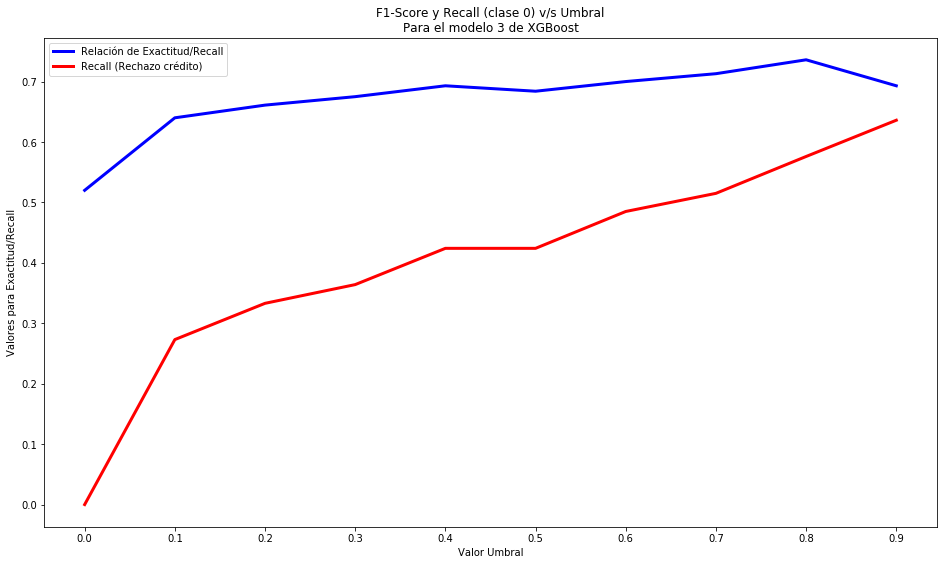

In [49]:
x_3, y_3 = zip(*list_fscores_3) # unpack a list of pairs into two tuples
x2_3, y2_3 = zip(*list_recalls_3)

fig_3 = plt.figure(figsize=(16,9))
ax_3 = fig_3.add_subplot(111)
ax_3.plot(x_3,y_3, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_3.plot(x2_3,y2_3, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_3.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 3 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_3.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.9 para el modelo 3.

In [50]:
pred3 = predict_(model3,X_test,0.9)

In [51]:
print('Reporte de clasificación para el modelo 3 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred3))}')

Reporte de clasificación para el modelo 3 de XGboost


              precision    recall  f1-score   support

           0       0.54      0.64      0.58        33
           1       0.79      0.71      0.75        63

    accuracy                           0.69        96
   macro avg       0.66      0.68      0.67        96
weighted avg       0.70      0.69      0.69        96



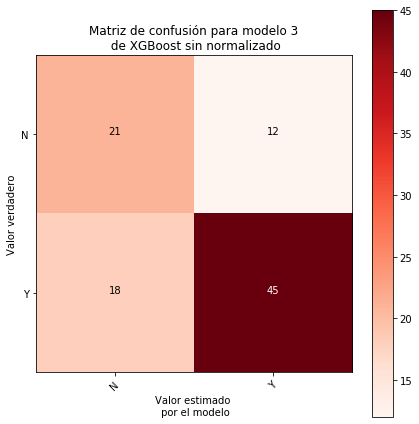

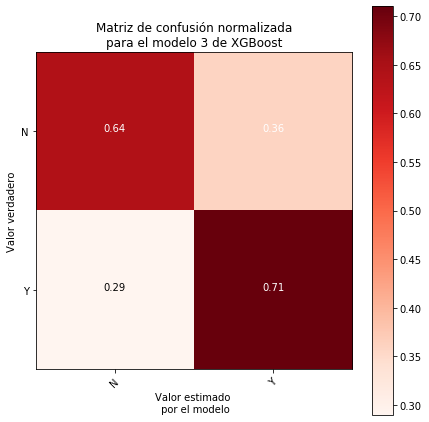

In [52]:
cnf_matrix_xgb3 = confusion_matrix(y_test.ravel(), pred3)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb3, classes=(['N','Y']), title='Matriz de confusión para modelo 3\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb3, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 3 de XGBoost')

plt.show()

In [53]:
print("Exactitud para el modelo 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

Exactitud para el modelo 3: 68.75


Area bajo la curva característica para el modelo 3: 0.675


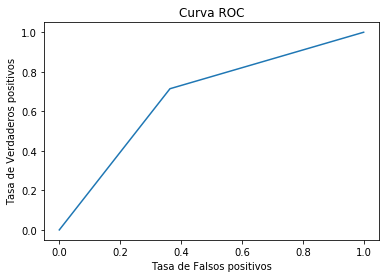

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, pred3)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 3:', 
      np.round(roc_auc_score(y_test, pred3),3))

### Modelo 4 de XGBoost, modificando los parámetros de profundidad y mínimo de pesos

In [55]:
#Se utilizará grid search para asignar los parámetros de profundidad y el mínimo de pesos
param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model4 = gsearch.fit(X_train, y_train)

D:\GAMER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


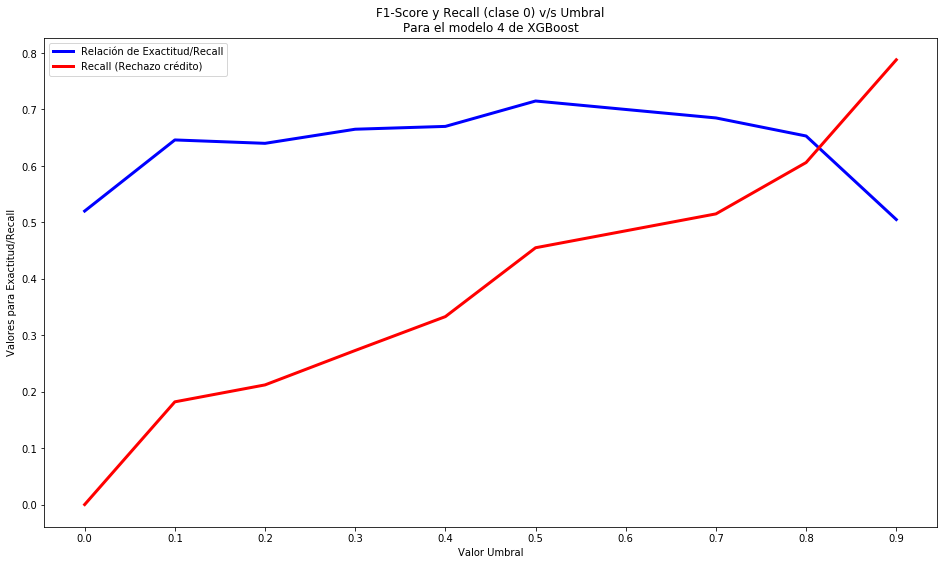

In [56]:
fscores_4,recalls_4 = mult_predict(model4,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_4 = sorted(fscores_4.items())
list_recalls_4 = sorted(recalls_4.items())

x_4, y_4 = zip(*list_fscores_4) # unpack a list of pairs into two tuples
x2_4, y2_4 = zip(*list_recalls_4)

fig_4 = plt.figure(figsize=(16,9))
ax_4 = fig_4.add_subplot(111)
ax_4.plot(x_4,y_4, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_4.plot(x2_4,y2_4, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_4.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 4 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_4.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.8 para el modelo 4.

In [57]:
pred4 = predict_(model4,X_test,0.82)
print('Reporte de clasificación para el modelo 4 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred4))}')

Reporte de clasificación para el modelo 4 de XGboost


              precision    recall  f1-score   support

           0       0.48      0.64      0.55        33
           1       0.77      0.63      0.70        63

    accuracy                           0.64        96
   macro avg       0.62      0.64      0.62        96
weighted avg       0.67      0.64      0.64        96



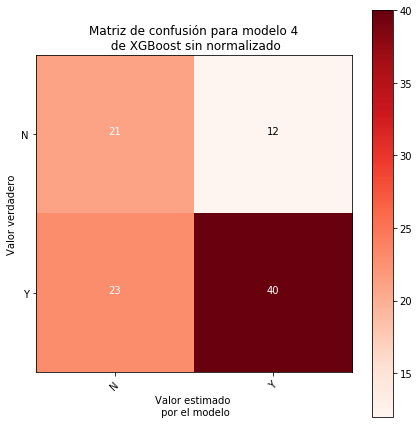

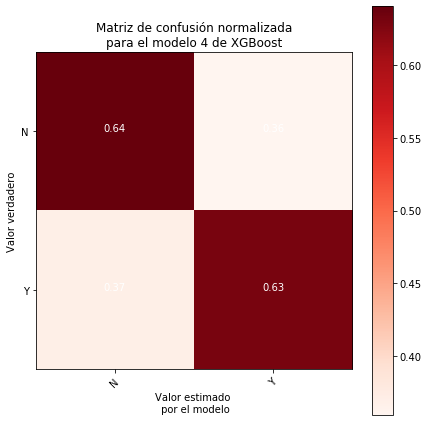

In [58]:
cnf_matrix_xgb4 = confusion_matrix(y_test.ravel(), pred4)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb4, classes=(['N','Y']), title='Matriz de confusión para modelo 4\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb4, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 4 de XGBoost')

plt.show()

In [59]:
print("Exactitud para el modelo 4: %.2f" % (accuracy_score(y_test, pred4) * 100))

Exactitud para el modelo 4: 63.54


Area bajo la curva característica para el modelo 4: 0.636


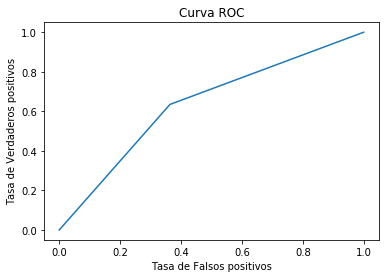

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, pred4)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 4:', 
      np.round(roc_auc_score(y_test, pred4),3))

#### Modelo XGBoost 5, modificando el parámetro Gamma

In [61]:
#Moviendo el parámetro gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model5 = gsearch3.fit(X_train, y_train)

D:\GAMER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


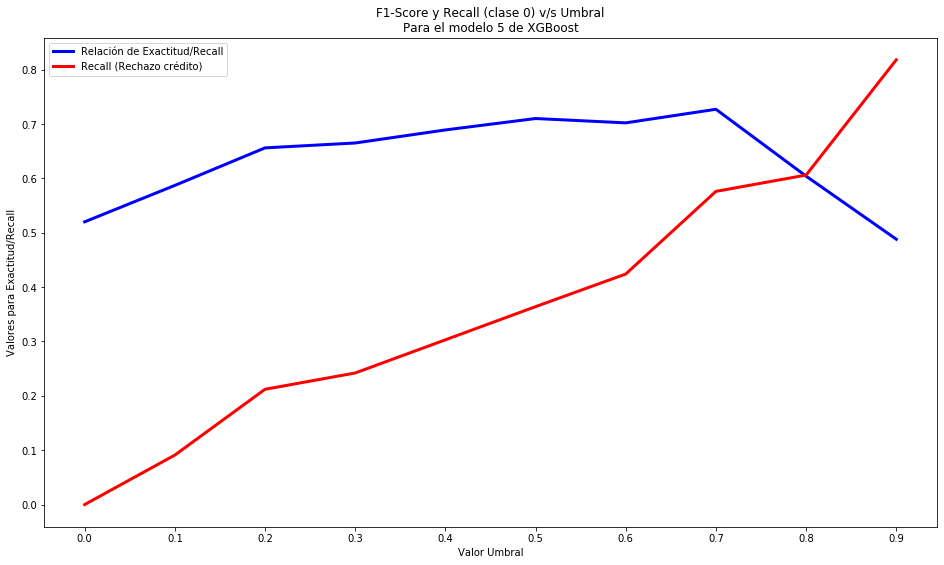

In [62]:
fscores_5,recalls_5 = mult_predict(model5,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_5 = sorted(fscores_5.items())
list_recalls_5 = sorted(recalls_5.items())

x_5, y_5 = zip(*list_fscores_5) # unpack a list of pairs into two tuples
x2_5, y2_5 = zip(*list_recalls_5)

fig_5 = plt.figure(figsize=(16,9))
ax_5 = fig_5.add_subplot(111)
ax_5.plot(x_5,y_5, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_5.plot(x2_5,y2_5, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_5.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 5 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_5.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.8 para el modelo 5.

In [65]:
pred5 = predict_(model5,X_test,0.75)
print('Reporte de clasificación para el modelo 5 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred5))}')

Reporte de clasificación para el modelo 5 de XGboost


              precision    recall  f1-score   support

           0       0.53      0.58      0.55        33
           1       0.77      0.73      0.75        63

    accuracy                           0.68        96
   macro avg       0.65      0.65      0.65        96
weighted avg       0.68      0.68      0.68        96



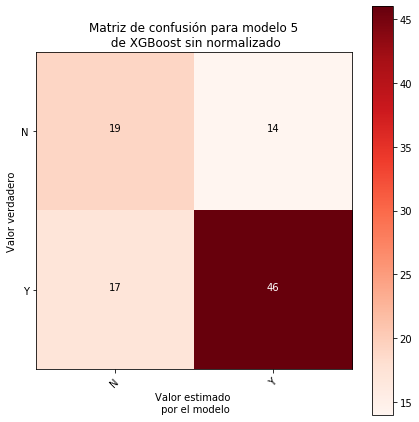

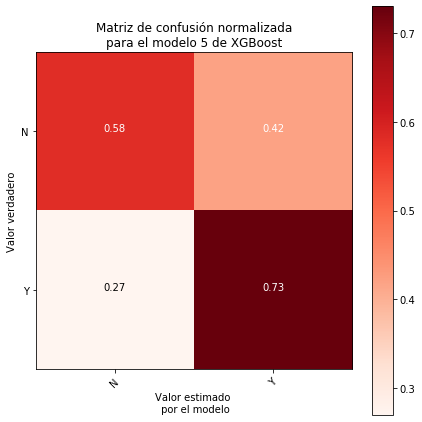

In [67]:
cnf_matrix_xgb5 = confusion_matrix(y_test.ravel(), pred5)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb5, classes=(['N','Y']), title='Matriz de confusión para modelo 5\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb5, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 5 de XGBoost')

plt.show()

In [68]:
print("Exactitud para el modelo 5: %.2f" % (accuracy_score(y_test, pred5) * 100))

Exactitud para el modelo 5: 67.71


Area bajo la curva característica para el modelo 5: 0.653


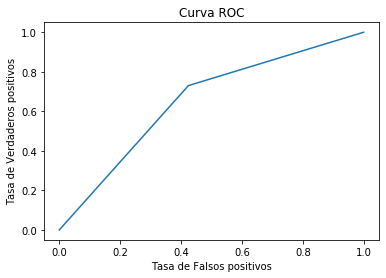

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, pred5)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 5:', 
      np.round(roc_auc_score(y_test, pred5),3))

#### Modelo de XGBoost 6, aumentando el learning rate

In [70]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.7,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model6 = xgb2.fit(X_train, y_train)

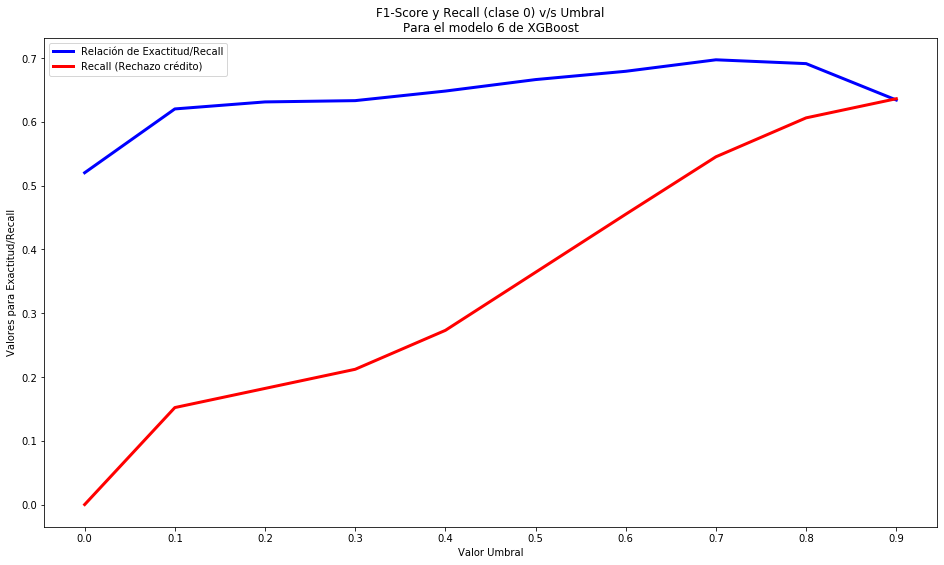

In [71]:
fscores_6,recalls_6 = mult_predict(model6,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_6 = sorted(fscores_6.items())
list_recalls_6 = sorted(recalls_6.items())

x_6, y_6 = zip(*list_fscores_6) # unpack a list of pairs into two tuples
x2_6, y2_6 = zip(*list_recalls_6)

fig_6 = plt.figure(figsize=(16,9))
ax_6 = fig_6.add_subplot(111)
ax_6.plot(x_6,y_6, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax_6.plot(x2_6,y2_6, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax_6.set(title='F1-Score y Recall (clase 0) v/s Umbral\nPara el modelo 6 de XGBoost',ylabel='Valores para Exactitud/Recall',xlabel='Valor Umbral')
ax_6.legend()
plt.show()

Por lo que un umbral sugerible para realizar las predicciones con las probabilidades de pertenencia a las clase 0 ("rechazo crédito") o clase 1 ("apruebo crédito") sería en un vecindario cercano a un valor de 0.9 para el modelo 6.

In [72]:
pred6 = predict_(model6,X_test,0.9)
print('Reporte de clasificación para el modelo 6 de XGboost')
print('\n')
print(f'{(classification_report(y_test, pred6))}')

Reporte de clasificación para el modelo 6 de XGboost


              precision    recall  f1-score   support

           0       0.47      0.64      0.54        33
           1       0.76      0.62      0.68        63

    accuracy                           0.62        96
   macro avg       0.62      0.63      0.61        96
weighted avg       0.66      0.62      0.63        96



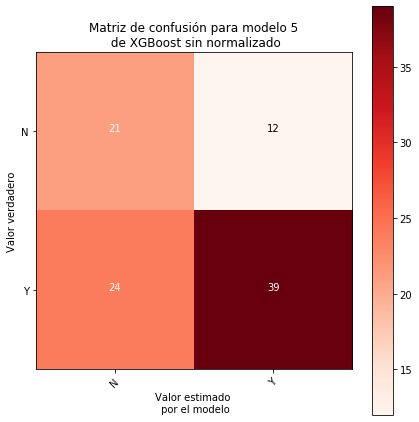

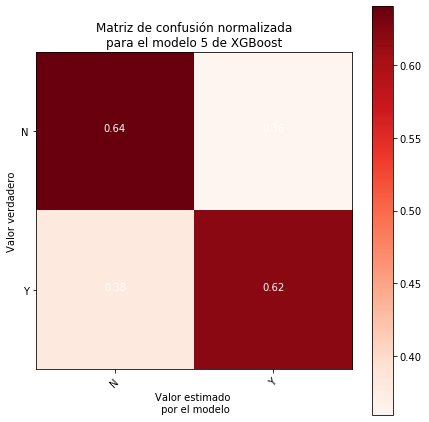

In [73]:
cnf_matrix_xgb6 = confusion_matrix(y_test.ravel(), pred6)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb6, classes=(['N','Y']), title='Matriz de confusión para modelo 5\n de XGBoost sin normalizado')

#Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_xgb6, classes=(['N','Y']), normalize=True, title='Matriz de confusión normalizada\npara el modelo 5 de XGBoost')

plt.show()

In [74]:
print("Exactitud para el modelo 6: %.2f" % (accuracy_score(y_test, pred6) * 100))

Exactitud para el modelo 6: 62.50


Area bajo la curva característica para el modelo 6: 0.628


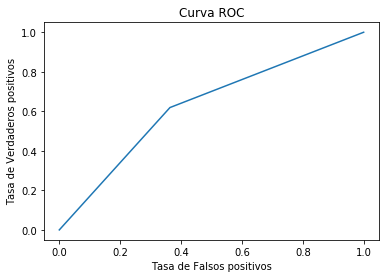

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, pred6)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo 6:', 
      np.round(roc_auc_score(y_test, pred6),3))

En resumen los desempeños para los distintos modelos de XGBoost se evaluarán con respecto a recall de la clase 0 (identificar correctamente a personas que se logran etiquetar "rechazar crédito" de entre todas las que se rechazan),
es decir que maximicen la cantidad de créditos correctamente rechazados.

- Modelo 1: Recall "rechazar crédito" - > 0.61
            Accuracy -> 0.59

- Modelo 2: Recall "rechazar crédito" - > 0.64
            Accuracy -> 0.69

- Modelo 3: Recall "rechazar crédito" - > 0.64
            Accuracy -> 0.69

- Modelo 4: Recall "rechazar crédito" - > 0.64
            Accuracy -> 0.64

- Modelo 5: Recall "rechazar crédito" - > 0.58
            Accuracy -> 0.66

- Modelo 6: Recall "rechazar crédito" - > 0.64
            Accuracy -> 0.62
            
Lo que corrobora la aseveración realizada anteriormente, tener una mejor exactitud no implica tener un mejor desempeño
en términos del negocio, por lo que el mejor modelo para efectos de asignar un préstamo sería el modelo 2 o 3 de XGBoost.

### Modelo Regresión Logística

Debido a que el modelo XGBoost es complejo y puede incurrir en overfitting o sobreajuste se utilizará un modelo de regresión logística más simple

In [76]:
clf_LR=(LogisticRegression(max_iter=1000))
clf_LR.fit(X_train,y_train.ravel())

LogisticRegression(max_iter=1000)

In [77]:
fscoreslr,recallslr = mult_predict(clf_LR,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_lr = sorted(fscoreslr.items())
list_recalls_lr = sorted(recallslr.items())

<Figure size 432x288 with 0 Axes>

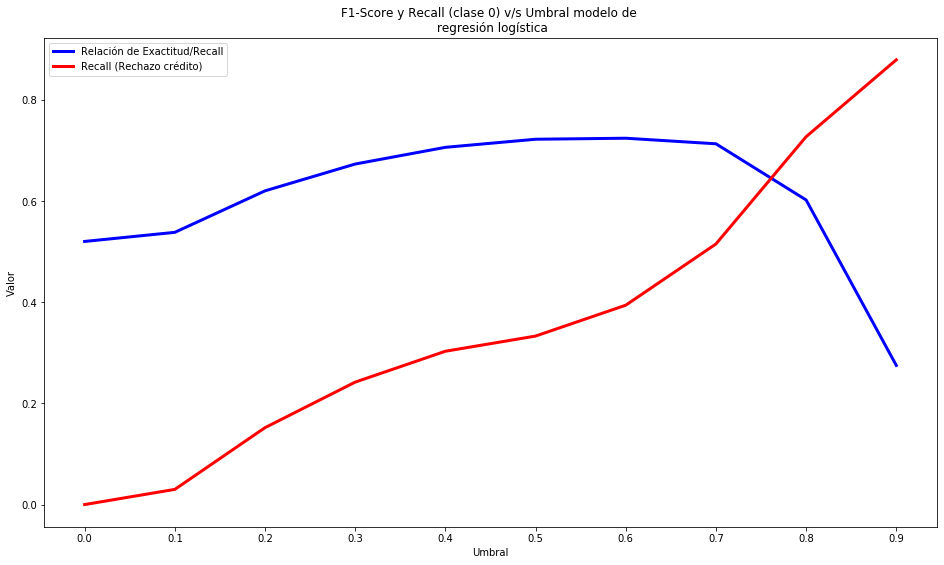

In [78]:
plt.clf()
x_lr, y_lr = zip(*list_fscores_lr) # unpack a list of pairs into two tuples
x2_lr, y2_lr = zip(*list_recalls_lr)

fig2 = plt.figure(figsize=(16,9))
ax2 = fig2.add_subplot(111)
ax2.plot(x_lr,y_lr, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
ax2.plot(x2_lr,y2_lr, color='red',linewidth=3,label='Recall (Rechazo crédito)')

ax2.set(title='F1-Score y Recall (clase 0) v/s Umbral modelo de \n regresión logística',ylabel='Valor',xlabel='Umbral')
ax2.legend()
plt.show()

In [79]:
y_pred_LR = predict_(clf_LR,X_test,0.77)

print('Clasificación por regresión logística')
print(classification_report(y_test.ravel(), y_pred_LR))

Clasificación por regresión logística
              precision    recall  f1-score   support

           0       0.43      0.61      0.51        33
           1       0.74      0.59      0.65        63

    accuracy                           0.59        96
   macro avg       0.59      0.60      0.58        96
weighted avg       0.64      0.59      0.60        96



Area bajo la curva característica para el modelo de regresión logística: 0.597


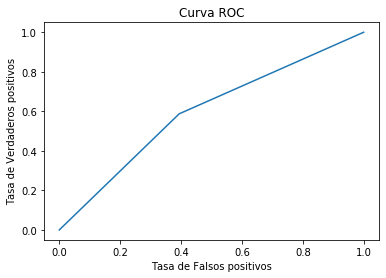

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LR)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo de regresión logística:', 
      np.round(roc_auc_score(y_test, y_pred_LR),3))

## Desempeño random forest

In [81]:
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, n_estimators=200, random_state=0)

In [82]:
fscoresrf,recallsrf = mult_predict(clf_rf,X_test,np.round(np.arange(0,1,0.1),3),y_test)
list_fscores_rf = sorted(fscoresrf.items())
list_recalls_rf = sorted(recallsrf.items())

<Figure size 432x288 with 0 Axes>

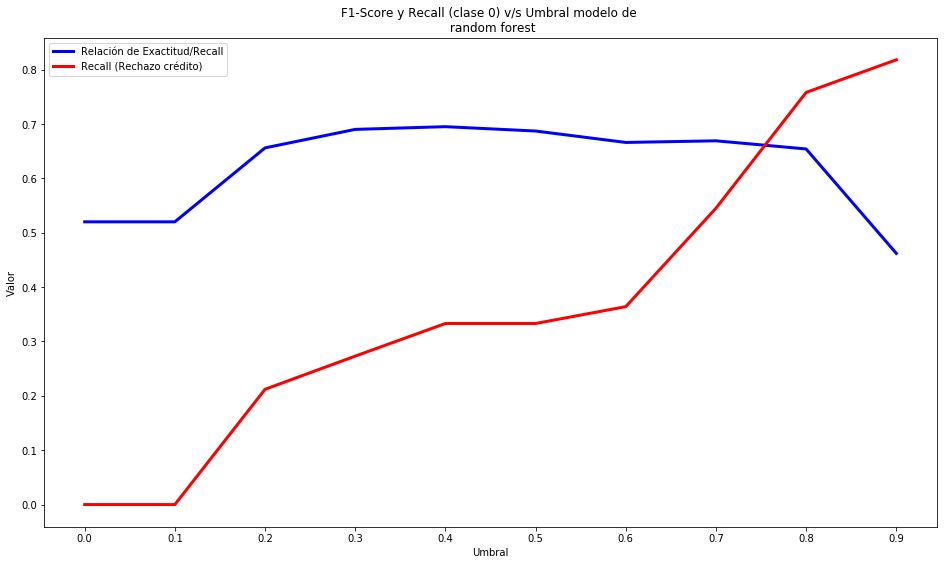

In [83]:
plt.clf()
x_rf, y_rf = zip(*list_fscores_rf) # unpack a list of pairs into two tuples
x2_rf, y2_rf = zip(*list_recalls_rf)

figrf = plt.figure(figsize=(16,9))
axrf = figrf.add_subplot(111)
axrf.plot(x_rf,y_rf, color='blue',linewidth=3,label='Relación de Exactitud/Recall')
axrf.plot(x2_rf,y2_rf, color='red',linewidth=3,label='Recall (Rechazo crédito)')

axrf.set(title='F1-Score y Recall (clase 0) v/s Umbral modelo de \n random forest',ylabel='Valor',xlabel='Umbral')
axrf.legend()
plt.show()

In [84]:
y_pred_rf = predict_(clf_rf,X_test,0.79)

print('Clasificador Random Forest')
print(classification_report(y_test.ravel(), y_pred_rf))

Clasificador Random Forest
              precision    recall  f1-score   support

           0       0.51      0.73      0.60        33
           1       0.82      0.63      0.71        63

    accuracy                           0.67        96
   macro avg       0.66      0.68      0.66        96
weighted avg       0.71      0.67      0.67        96



Area bajo la curva característica para el modelo de random forest: 0.681


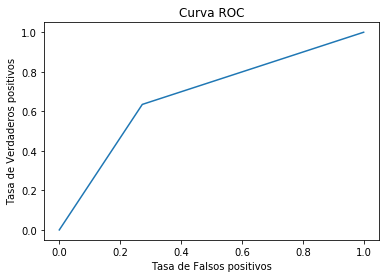

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
print('Area bajo la curva característica para el modelo de random forest:', 
      np.round(roc_auc_score(y_test, y_pred_rf),3))

Obteniéndose un desempeño bastante aceptable con un Recall de 0.73 en clase "rechazo crédito" y una exactitud de 0.67, por lo que el modelo más recomendable para realizar las predicciones sería preliminarmente el random forest